In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
class Model(nn.Module):
    def __init__(self, inputs, outputs, hidden, n_layers):
        super().__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(inputs, hidden))
        layers.append(nn.Tanh())
        
        # Hidden layers
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(0.0))
        
        # Output layer
        layers.append(nn.Linear(hidden, outputs))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights using Xavier initialization
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.network(x)

In [11]:
def infer_with_model(model: Model, weights, y):
    model.load_state_dict(weights)

    return model(y)

In [12]:
testfile = "Tests/Test/test.pt"

/tmp/ipykernel_10409/740674254.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(testfile, map_location=torch.device("cpu"))


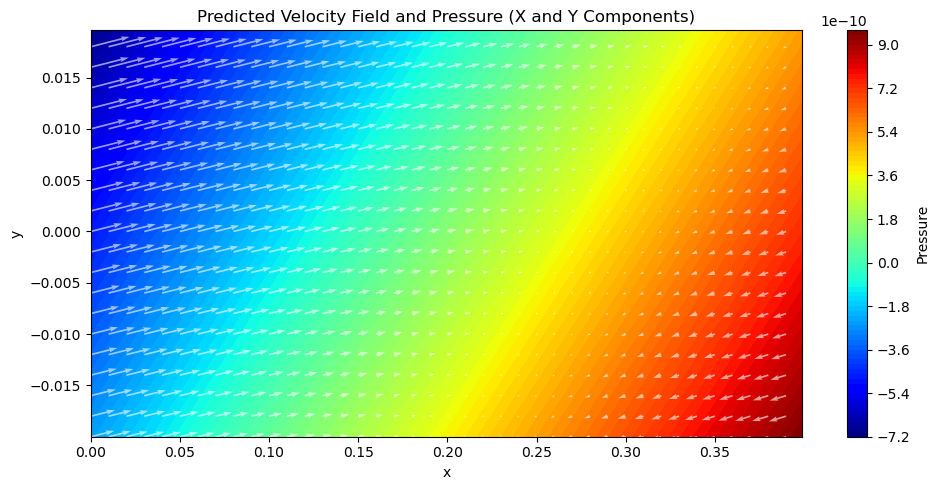

In [13]:
weights = torch.load(testfile, map_location=torch.device("cpu"))
poiseuille_model = Model(2, 3, 100, 12).to("cpu")

to_infer = []

for i in range(-50, 50, 1):
    for j in range(0, 400, 1):
        to_infer.append([j/1000, i/2500])

to_infer = np.array(to_infer, dtype="float32")

yhp = infer_with_model(poiseuille_model, weights, torch.from_numpy(to_infer))

u_pred = yhp[:, 0].detach().cpu().numpy()
v_pred = yhp[:, 1].detach().cpu().numpy()
p_pred = yhp[:, 2].detach().cpu().numpy()
x = to_infer[:, 0]
y = to_infer[:, 1]

# Create dataframe
df = pd.DataFrame({'x': x, 'y': y, 'u': u_pred, 'v': v_pred, 'p':p_pred})
df['speed'] = p_pred

# Pivot for grid-based plotting
pivot_x = df.pivot_table(index='y', columns='x', values='u')
pivot_y = df.pivot_table(index='y', columns='x', values='v')
pivot_speed = df.pivot_table(index='y', columns='x', values='speed')

# Get meshgrid
X, Y = np.meshgrid(pivot_x.columns.values, pivot_x.index.values)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.contourf(X, Y, pivot_speed.values, levels=100, cmap='jet')
cb = fig.colorbar(c, ax=ax, label='Pressure')

# Optional quiver (velocity vectors, skip some for clarity)
skip = (slice(None, None, 5), slice(None, None, 10))
ax.quiver(X[skip], Y[skip], pivot_x.values[skip], pivot_y.values[skip], color='white', alpha=0.6)

# Styling
ax.set_title('Predicted Velocity Field and Pressure (X and Y Components)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('auto')
plt.tight_layout()
plt.show()

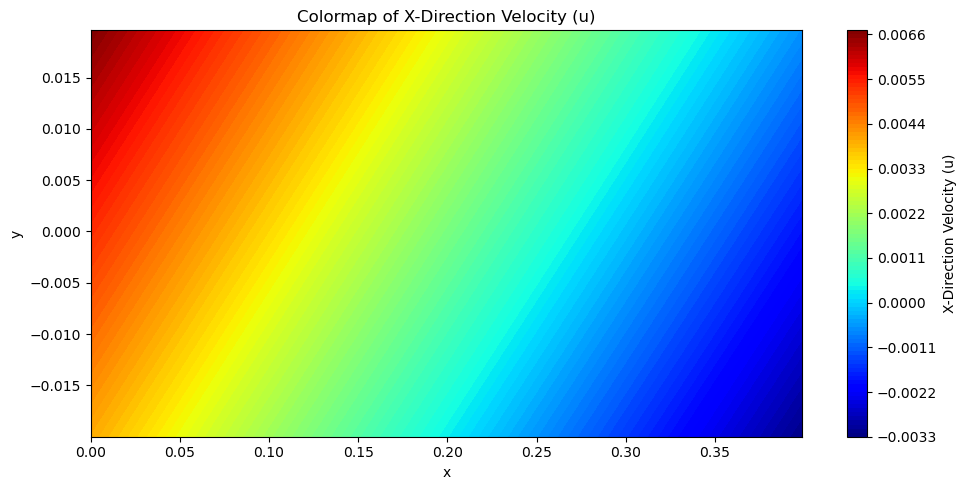

In [14]:
# Update 'speed' column to store x-direction speed
df['speed'] = df['u']  # instead of pressure

# Re-pivot for new speed values (which now represent x-direction speed)
pivot_speed_x = df.pivot_table(index='y', columns='x', values='speed')

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.contourf(X, Y, pivot_speed_x.values, levels=100, cmap='jet')  # 'plasma' or 'jet' or any colormap you like
cb = fig.colorbar(c, ax=ax, label='X-Direction Velocity (u)')

# Optional: Add quiver if desired
# ax.quiver(X[skip], Y[skip], pivot_x.values[skip], pivot_y.values[skip], color='white', alpha=0.6)

# Styling
ax.set_title('Colormap of X-Direction Velocity (u)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('auto')
plt.tight_layout()
plt.show()

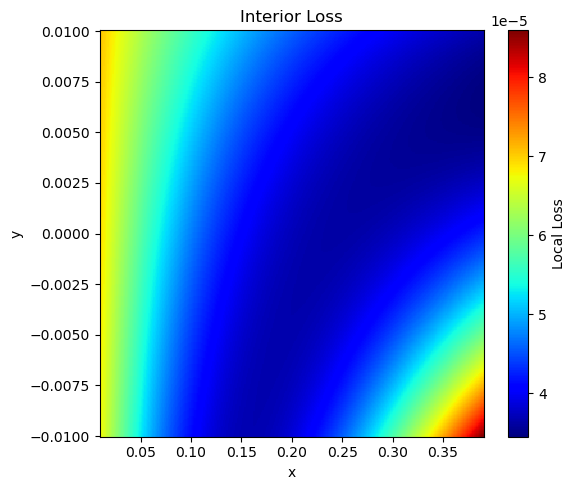

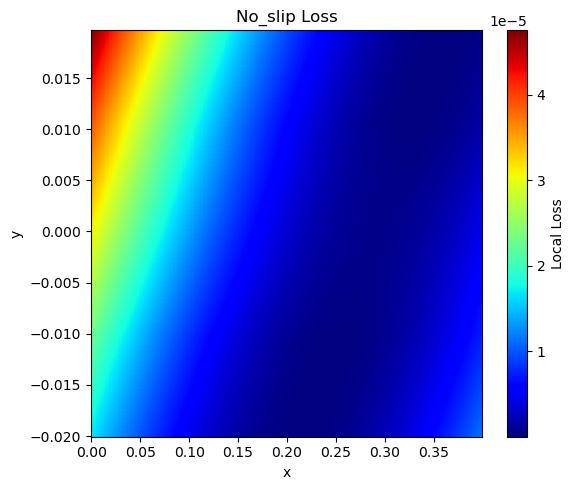

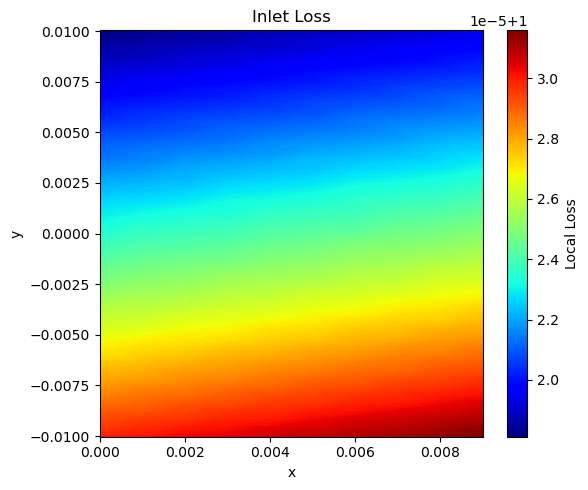

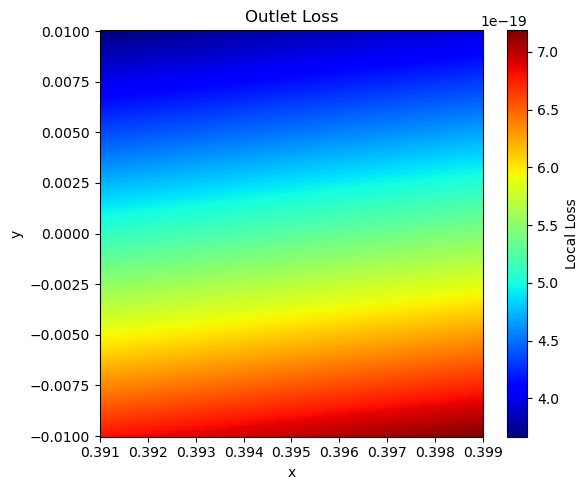

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

rho = 1000
mu = 0.001
u_avg = 0.01  # Replace this with your actual u_avg value

def compute_PDE(xy, y_in):
    u = y_in[:, 0:1]
    v = y_in[:, 1:2]
    p = y_in[:, 2:3]
    grads = lambda out, inp: torch.autograd.grad(
        out, inp, grad_outputs=torch.ones_like(out), create_graph=True
    )[0]
    grads_u = grads(u, xy)
    grads_v = grads(v, xy)
    grads_p = grads(p, xy)
    dudx, dudy = grads_u[:, 0], grads_u[:, 1]
    dvdx, dvdy = grads_v[:, 0], grads_v[:, 1]
    dpdx, dpdy = grads_p[:, 0], grads_p[:, 1]
    d2udx2 = grads(dudx, xy)[:, 0]
    d2udy2 = grads(dudy, xy)[:, 1]
    d2vdx2 = grads(dvdx, xy)[:, 0]
    d2vdy2 = grads(dvdy, xy)[:, 1]
    return dudx, dudy, dpdx, dpdy, d2udx2, d2udy2, dvdx, dvdy, d2vdx2, d2vdy2

def compute_losses_by_mask(model, inputs, masks, mask_names):
    """
    Returns a list of (name, coords, losses) for each mask in masks.
    """
    results = []
    
    for name, mask in zip(mask_names, masks):
        x = inputs[mask]
        # only interior needs requires_grad:
        if name == "interior":
            x = x.clone().detach().requires_grad_(True)
        y = model(x)

        if name == "interior":
            # physics loss
            dudx, dudy, dpdx, dpdy, d2udx2, d2udy2, dvdx, dvdy, d2vdx2, d2vdy2 = compute_PDE(x, y)
            navier_x = rho*(y[:,0]*dudx + y[:,1]*dudy) + dpdx - mu*(d2udx2 + d2udy2)
            navier_y = rho*(y[:,0]*dvdx + y[:,1]*dvdy) + dpdy - mu*(d2vdx2 + d2vdy2)
            continuity = dudx + dvdy
            loss = navier_x**2 + navier_y**2 + 1000*(continuity**2)

        elif name == "no_slip":
            loss = y[:, 0]**2 + (y[:, 1]**2)

        elif name == "inlet":
            loss = (y[:, 0] - u_avg)**2 + y[:, 1]**2 + ( (y[:, 2] - 1)**2 )

        elif name == "outlet":
            loss = (y[:, 2]**2)

        else:
            raise ValueError(f"Unknown mask name {name}")

        # detach, move to cpu & numpy later in plotting
        results.append((
            name,
            x.detach().cpu(),
            loss.detach().cpu()
        ))

    return results

def plot_filled_loss(coords, losses, title, resolution=300):
    x = coords[:, 0].numpy()
    y = coords[:, 1].numpy()
    z = losses.numpy()

    xi = np.linspace(x.min(), x.max(), resolution)
    yi = np.linspace(y.min(), y.max(), resolution)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='linear')

    plt.figure(figsize=(6,5))
    im = plt.pcolormesh(xi, yi, zi, shading='auto', cmap='jet')
    plt.colorbar(im, label='Local Loss')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.axis('auto')
    plt.tight_layout()
    plt.show()


# --- set up your masks & inputs just like before ---

# assume to_infer is an (N,2) numpy array of [x,y] points
x_vals = torch.from_numpy(to_infer[:,0])
y_vals = torch.from_numpy(to_infer[:,1])
h = 0.01
L = 0.4

no_slip_mask = (y_vals < -h) | (y_vals > h)
inlet_mask   = (torch.abs(x_vals - 0) < 1e-2) & (~no_slip_mask)
outlet_mask  = (torch.abs(x_vals - L) < 1e-2) & (~no_slip_mask)
interior_mask = ~(no_slip_mask | inlet_mask | outlet_mask)

masks      = (interior_mask, no_slip_mask, inlet_mask, outlet_mask)
mask_names = ("interior", "no_slip", "inlet", "outlet")

inputs = torch.from_numpy(to_infer).float()

# compute per‐mask losses
results = compute_losses_by_mask(poiseuille_model, inputs, masks, mask_names)

# plot each
for name, coords, loss in results:
    plot_filled_loss(coords, loss, title=f"{name.capitalize()} Loss")


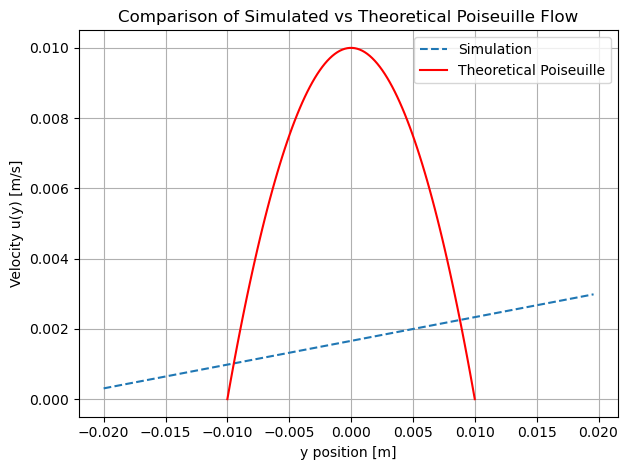

In [16]:
plt.plot(
    df[df['x'] == 0.2]["y"],
    df[df['x'] == 0.2]['u'].values,
    label='Simulation',
    linestyle='--'
)

real = []
indices = []
h = 0.01          # half channel height
ubar = 0.01       # average velocity
N = 100           # number of points

for i in range(N):
    y = -h + (2 * h) * i / (N - 1)  # evenly spaced from -h to +h
    indices.append(y)
    u = ubar * (1 - (y**2) / (h**2))
    real.append(u)

plt.plot(indices, real, label='Theoretical Poiseuille', color='red')

plt.xlabel('y position [m]')
plt.ylabel('Velocity u(y) [m/s]')
plt.title('Comparison of Simulated vs Theoretical Poiseuille Flow')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
